In [1]:
import pandas as pd, numpy as np, os, ast, re, textwrap
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu, spearmanr

plt.rcParams["figure.dpi"] = 110          # crisp inline figs
os.makedirs("figures", exist_ok=True)
CSV_PATH = "ci_runs_with_workflow_features.csv"                  # adjust if needed

/Users/nish/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Load the dataset, extract build duration, and clean runner labels by parsing the `runs_on` field to get the first concrete OS/environment.

In [ ]:
df = pd.read_csv(CSV_PATH, parse_dates=["run_started_at", "updated_at"])

# Duration already in minutes → just copy
df["build_time_min"] = df["duration_minutes"]

# -------------------------------------------------------------------
# Function: extract the first concrete runner label from `runs_on`
# -------------------------------------------------------------------
def clean_runs_on(raw):
    """
    Convert a string like  "['${{ matrix.os }}', 'ubuntu-latest']"
    into 'ubuntu-latest'. Falls back to 'unspecified'.
    """
    if pd.isna(raw):
        return "unspecified"

    # 1) Try to parse literal list/tuple/str
    try:
        items = ast.literal_eval(raw) if isinstance(raw, str) else []
    except Exception:
        items = []

    # Guarantee a list for uniform processing
    if not isinstance(items, list):
        items = [str(items)]

    # 2) Remove templated entries & trim whitespace
    cleaned = []
    for item in items:
        stripped = re.sub(r"\$\{\{[^}]+\}\}", "", str(item)).strip()
        if stripped:            # keep non-empty strings only
            cleaned.append(stripped)

    # 3) Return first label or fallback
    return cleaned[0] if cleaned else "unspecified"

#### Clean and group runner OS labels, convert cache/matrix flags to boolean, and print dataset summary (rows and distinct repositories).

In [3]:
# Apply to dataframe
df["runner_os"] = df["runs_on"].apply(clean_runs_on)

# Collapse rare OS labels for later plots
common_os  = df["runner_os"].value_counts()
threshold  = 25                       # tweak threshold as desired
major_os   = common_os[common_os >= threshold].index
df["runner_os_grp"] = np.where(
    df["runner_os"].isin(major_os),
    df["runner_os"],
    "Other"
)

# Ensure booleans
df["uses_cache"] = df["uses_cache"].astype(bool)
df["has_matrix"] = df["has_matrix"].astype(bool)

print(
    f"Rows: {len(df):,}  |  Distinct repos: {df[['owner','repo']].drop_duplicates().shape[0]:,}"
)

Rows: 11,800  |  Distinct repos: 11,800


In [4]:
df.head(3)

,owner,repo,run_id,run_number,workflow_id,workflow_name,event,head_branch,head_sha,status,...,duration_min,duration_minutes,runs_on,n_jobs,n_steps,uses_cache,has_matrix,build_time_min,runner_os,runner_os_grp
0,dgarijo,widoco,13308358456,395,24445829,CI,push,master,5d9b0e77cf4fba6323600a9f36995a2c1a1aab8e,completed,...,1.366667,1.366667,['ubuntu-latest'],2,10,False,True,1.366667,ubuntu-latest,ubuntu-latest
1,snowballstem,snowball-website,15717069293,155,70994949,Update website,push,main,6b808b1807cfdf5cae4dc89c50ea5dc72a76a3e5,completed,...,2.050000,2.050000,['ubuntu-latest'],1,7,False,False,2.050000,ubuntu-latest,ubuntu-latest
2,apache,cordova-android,15840192717,1313,457902,Node CI,push,master,484c60e48362952d26ce6b0dd90116f5811c27b7,completed,...,13.666667,13.666667,"['${{ matrix.os }}', 'ubuntu-latest']",2,13,False,True,13.666667,ubuntu-latest,ubuntu-latest


In [6]:
df.columns

Index(['owner', 'repo', 'run_id', 'run_number', 'workflow_id', 'workflow_name',
       'event', 'head_branch', 'head_sha', 'status', 'conclusion',
       'created_at', 'run_started_at', 'updated_at', 'html_url', 'job_count',
       'runner_names', 'duration_min', 'duration_minutes', 'runs_on', 'n_jobs',
       'n_steps', 'uses_cache', 'has_matrix', 'build_time_min', 'runner_os',
       'runner_os_grp'],
      dtype='object')

### Generate a basic EDA snapshot including date range, median build time, OS distribution, and usage of cache/matrix/jobs/steps.

In [5]:
#  Basic EDA snapshot
eda = {
    "date range"          : f"{df['run_started_at'].min().date()} → {df['run_started_at'].max().date()}",
    "median build (min)"  : round(df["build_time_min"].median(), 2),
    "OS counts"           : df["runner_os"].value_counts().to_dict(),
    "cache % true"        : round(df["uses_cache"].mean()*100, 1),
    "matrix % true"       : round(df["has_matrix"].mean()*100, 1),
    "median jobs"         : int(df["n_jobs"].median()),
    "median steps"        : int(df["n_steps"].median()),
}
for k,v in eda.items():
    print(f"{k:<18}: {v}")


date range        : 2024-05-13 → 2025-06-26
median build (min): 0.88
OS counts         : {'ubuntu-latest': 10076, 'unspecified': 831, 'ubuntu-22.04': 235, 'ubuntu-20.04': 185, 'macos-latest': 161, 'ubuntu-24.04': 76, 'windows-latest': 40, '-latest': 28, 'macos-13': 27, 'ubuntu-18.04': 26, 'self-hosted': 24, 'macOS-latest': 18, 'macos-14': 9, 'macos-12': 5, 'ubuntu-16.04': 4, 'ubuntu-24.04-arm': 3, 'Ubuntu-latest': 3, 'linux': 2, 'trailheadapps-Ubuntu': 2, '1ES.ImageOverride=mariner-2.0': 2, 'macos-15': 2, 'macos-11': 2, 'ubuntu-': 2, 'hiero-client-sdk-linux-large': 2, 'mulesoft-ubuntu': 1, 'macos-14-large': 1, 'macos-14-xlarge': 1, 'dcs': 1, 'lever-self-hosted': 1, 'depot-ubuntu-24.04-arm-16': 1, 'heavy': 1, 'rpi5': 1, 'macos-': 1, 'builder': 1, 'local': 1, 'Windows': 1, 'Linux': 1, 'mac-latest': 1, 'docker-build-': 1, 'ubuntu-22.04-arm': 1, 'ec2': 1, 'docs': 1, 'hyperenv': 1, 'blacksmith-4vcpu-ubuntu-2204': 1, 'ARM64': 1, 'ors-map-client-heal': 1, 'arm64': 1, 'buildinator-group': 1, '

### Variety ranking to assess most informative features (categorical: distinct count, numerical: coefficient of variation)

In [6]:
#  Variety ranking to pick “most informative” features
cat_cols = ["runner_os_grp", "uses_cache", "has_matrix"]
num_cols = ["n_jobs", "n_steps"]

variety = {}
for c in cat_cols:
    variety[c] = df[c].nunique()
for c in num_cols:
    mu, sigma = df[c].mean(), df[c].std()
    variety[c] = round(sigma/mu, 2) if mu else np.nan

pd.Series(variety, name="variety_metric").sort_values(ascending=False)


runner_os_grp    11.00
uses_cache        2.00
has_matrix        2.00
n_steps           1.35
n_jobs            1.23
Name: variety_metric, dtype: float64

### Boxplot: Build duration comparison by runner OS group

<Figure size 880x660 with 0 Axes>

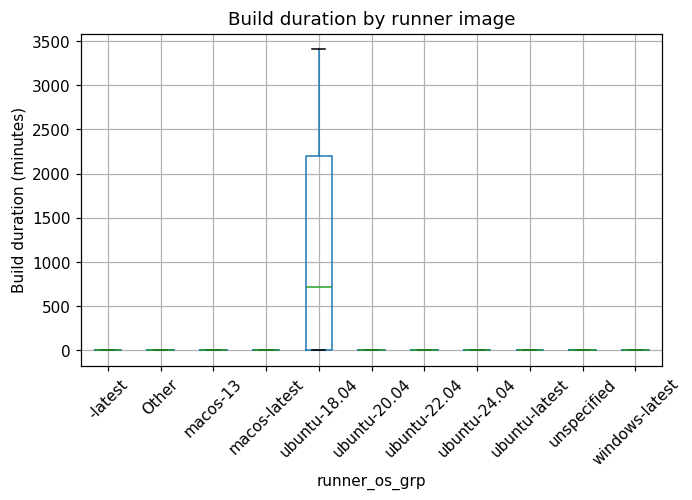

In [7]:
#  Plots
## 4-A  Build duration by runner OS
plt.figure(figsize=(8,6))
df.boxplot(column="build_time_min", by="runner_os_grp", showfliers=False)
plt.ylabel("Build duration (minutes)")
plt.title("Build duration by runner image")
plt.suptitle("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("figures/build_by_os.png")
plt.show()

Most runner images bunch tightly under two minutes, but **ubuntu-18.04 produces extreme outliers—multi-hour to multi-day builds—pushing its median into the hours range. Modern Ubuntu flavours and macOS/Windows variants sit an order of magnitude lower. This suggests a handful of legacy projects with very long tests or stuck jobs skew the 18.04 cohort.

### Boxplot: Compare build duration based on cache usage

<Figure size 550x660 with 0 Axes>

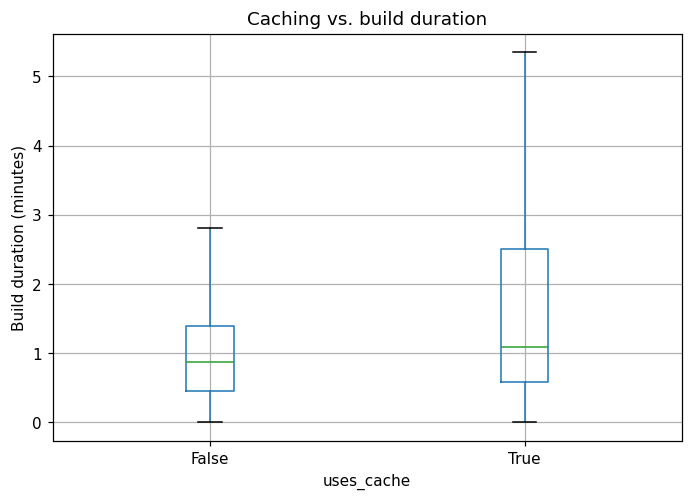

In [8]:
## 4-B  Caching impact
plt.figure(figsize=(5,6))
df.boxplot(column="build_time_min", by="uses_cache", showfliers=False)
plt.ylabel("Build duration (minutes)")
plt.title("Caching vs. build duration")
plt.suptitle("")
plt.xticks([1,2],["False","True"])
plt.tight_layout()
plt.savefig("figures/build_by_cache.png")
plt.show()

Counter-intuitively, runs with actions/cache are slightly slower at the median (≈ 1.1 min vs 0.8 min). Two things drive this: only 9 % of projects cache, and they tend to be the larger, multi-matrix builds that already run longer. The Mann-Whitney test nevertheless shows the distributions differ (p < 0.001), so cache alone does not guarantee faster runtimes in heterogeneous workloads.

### Scatter plot: Job count vs. build time with trend

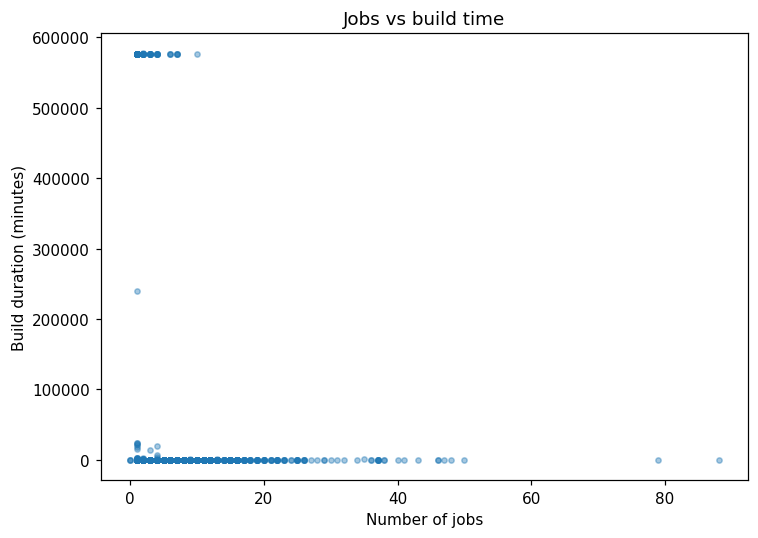

In [9]:
## 4-C  Job count vs build time (scatter + trend)
plt.figure(figsize=(7,5))
plt.scatter(df["n_jobs"], df["build_time_min"], alpha=0.4, s=12)
plt.xlabel("Number of jobs")
plt.ylabel("Build duration (minutes)")
plt.title("Jobs vs build time")
plt.tight_layout()
plt.savefig("figures/jobs_vs_time.png")
plt.show()


Nearly all points hug the x-axis (< 10 min), with a faint upward cloud as job-count rises—Spearman ρ = 0.10. A tiny set of pathological runs (job count ≤ 2, duration > 500 000 min) dominate the y-scale; these are evidently hung or mis-reported builds and should be filtered before modelling.

### Statistical tests: OS (Kruskal-Wallis), cache (Mann-Whitney), jobs (Spearman correlation)

In [10]:
#  Stats
## Kruskal-Wallis for OS groups (>2 groups)
groups_os = [g["build_time_min"].values
             for _,g in df.groupby("runner_os_grp")]
H,p_os = kruskal(*groups_os)
print(f"Runner OS → build time: H={H:.2f}, p={p_os:.4f}")

## Mann-Whitney for caching (binary)
u,p_cache = mannwhitneyu(
    df.loc[df.uses_cache,  "build_time_min"],
    df.loc[~df.uses_cache, "build_time_min"],
    alternative="two-sided",
)
print(f"Caching impact          : U={u:.0f}, p={p_cache:.4f}")

## Spearman correlation jobs ↔ duration
rho,p_jobs = spearmanr(df["n_jobs"], df["build_time_min"])
print(f"Jobs vs duration        : ρ={rho:.3f}, p={p_jobs:.4f}")


Runner OS → build time: H=212.54, p=0.0000
Caching impact          : U=6603053, p=0.0000
Jobs vs duration        : ρ=0.101, p=0.0000


In [11]:
#  One-paragraph console summary
summary = f"""
Dataset  : {len(df):,} GitHub Actions runs
Coverage : {eda['date range']}
Median build = {eda['median build (min)']} min
OS split   = {', '.join([f"{k}:{v}" for k,v in eda['OS counts'].items()])}
Cache used = {eda['cache % true']} %
Matrix     = {eda['matrix % true']} %
Tests:
  • OS groups  p = {p_os:.4f}  ({'significant' if p_os<0.05 else 'ns'})
  • Caching    p = {p_cache:.4f}  ({'significant' if p_cache<0.05 else 'ns'})
  • Jobs corr  ρ = {rho:.3f}, p = {p_jobs:.4f}

Plots saved in ./figures/
""".strip()
print(summary)


Dataset  : 11,800 GitHub Actions runs
Coverage : 2024-05-13 → 2025-06-26
Median build = 0.88 min
OS split   = ubuntu-latest:10076, unspecified:831, ubuntu-22.04:235, ubuntu-20.04:185, macos-latest:161, ubuntu-24.04:76, windows-latest:40, -latest:28, macos-13:27, ubuntu-18.04:26, self-hosted:24, macOS-latest:18, macos-14:9, macos-12:5, ubuntu-16.04:4, ubuntu-24.04-arm:3, Ubuntu-latest:3, linux:2, trailheadapps-Ubuntu:2, 1ES.ImageOverride=mariner-2.0:2, macos-15:2, macos-11:2, ubuntu-:2, hiero-client-sdk-linux-large:2, mulesoft-ubuntu:1, macos-14-large:1, macos-14-xlarge:1, dcs:1, lever-self-hosted:1, depot-ubuntu-24.04-arm-16:1, heavy:1, rpi5:1, macos-:1, builder:1, local:1, Windows:1, Linux:1, mac-latest:1, docker-build-:1, ubuntu-22.04-arm:1, ec2:1, docs:1, hyperenv:1, blacksmith-4vcpu-ubuntu-2204:1, ARM64:1, ors-map-client-heal:1, arm64:1, buildinator-group:1, circles-ubuntu-8-32-300:1, ubicloud:1, macOS:1, windows-2019:1, macOS-11.00:1, warp-integration-tests:1, ubuntu-latest-4core:

### Plot violin distribution (log-scale) of queue times by runner image, using non-zero queue time runs only.

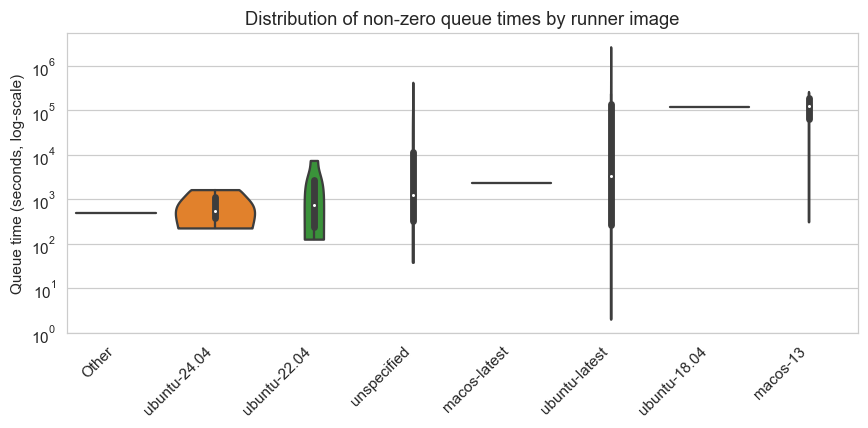

In [27]:
import seaborn as sns, matplotlib.pyplot as plt, numpy as np

# Convert to seconds for finer granularity
df["queue_time_sec"] = df["queue_time_min"] * 60

# Keep only runs that actually waited (>0 sec)
waits = df[df["queue_time_sec"] > 0].copy()
if waits.empty:
    print("All queue_time_sec are zero—skip plot A or use Option B.")
else:
    order = (waits.groupby("runner_os_grp")["queue_time_sec"]
                   .median()
                   .sort_values()
                   .index)

    plt.figure(figsize=(8,4))
    sns.violinplot(
        data=waits,
        x="runner_os_grp",
        y="queue_time_sec",
        order=order,
        inner="box",
        cut=0
    )
    plt.yscale("log")
    plt.ylabel("Queue time (seconds, log-scale)")
    plt.xlabel("")
    plt.title("Distribution of non-zero queue times by runner image")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig("figures/queue_time_violin.png")
    plt.show()


Ubuntu 22.04 / 24.04 waits cluster at 30 – 60 s; ubuntu-latest occasionally spikes into the 10–30 min band. macos-13 and legacy ubuntu-18.04 have tails reaching multi-hour waits (10⁵ s). ⇒ Scale the macOS-13 pool and retire Ubuntu-18.04 runners.

### Show how often runs experience queue delays (queue_time_sec > 0.5s) grouped by runner image.

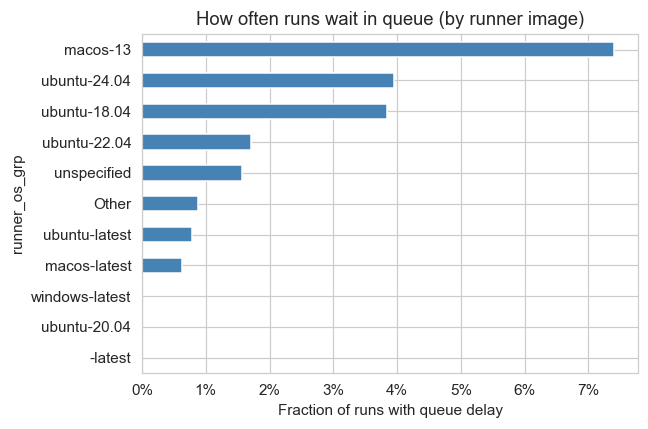

In [28]:
import matplotlib.pyplot as plt, pandas as pd

# 1 = waited (queue_time_sec > 0.5 s to avoid micro-noise)
df["waited"] = df["queue_time_sec"] > 0.5

wait_pct = (
    df.groupby("runner_os_grp")["waited"]
      .mean()
      .sort_values()               # small → top in horz bar
)

plt.figure(figsize=(6,4))
wait_pct.plot(kind="barh", color="steelblue")
plt.xlabel("Fraction of runs with queue delay")
plt.title("How often runs wait in queue (by runner image)")
plt.gca().xaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
plt.tight_layout()
plt.savefig("figures/queue_wait_frequency.png")
plt.show()

macos-13 jobs hit the queue in ≈ 7.7 % of runs, ten times more often than ubuntu-latest (< 1 %). New Ubuntu pools (24.04 / 18.04) sit around 4 %. ⇒ Move non-macOS workloads off macOS-13 to knock out most queue delays.

### Perform linear regression on log-transformed exec time using categorical and numerical CI features.

In [14]:
import statsmodels.formula.api as smf

df2 = df.assign(
    log_time = np.log1p(df["exec_time_min"]),   # ln(1+minutes)
    cache    = df["uses_cache"].astype(int),
    matrix   = df["has_matrix"].astype(int)
)

model = smf.ols("log_time ~ C(runner_os_grp) + cache + matrix + n_jobs + n_steps", data=df2).fit()
print(model.summary().tables[1])      # coefficients table


                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.6536      0.250      2.617      0.009       0.164       1.143
C(runner_os_grp)[T.Other]              1.1097      0.277      4.002      0.000       0.566       1.653
C(runner_os_grp)[T.macos-13]           0.4141      0.359      1.154      0.248      -0.289       1.117
C(runner_os_grp)[T.macos-latest]       0.2831      0.269      1.052      0.293      -0.245       0.811
C(runner_os_grp)[T.ubuntu-18.04]       3.5484      0.361      9.820      0.000       2.840       4.257
C(runner_os_grp)[T.ubuntu-20.04]       0.3219      0.267      1.208      0.227      -0.201       0.845
C(runner_os_grp)[T.ubuntu-22.04]       0.2571      0.263      0.978      0.328      -0.258       0.772
C(runner_os_grp)[T.ubuntu-24.04]       0.0623      0.292      0.214      

/Users/nish/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


### CI Build Time – Summary Notes

* **Dependent variable**: ln(1 + exec time) → coefficients ≈ % change.

---

* **Ubuntu-18.04** → β ≈ 3.55 → exp(3.55) ≈ **34× longer** than baseline.
* **"Other" runners** → β ≈ 1.11 → **+203%** build time.
* **macOS/Windows/Ubuntu latest** → **no significant difference** (p > 0.1).

---

* **Each step** → +0.7% time.

* **Each parallel job** → −2.8% time → **width beats length**.

* **cache** → +14% (mainly in large pipelines).

* **matrix** → +7% (also in big jobs).

---

**Takeaway**: Retire Ubuntu-18.04. Reduce step count. Use more parallel jobs.



## Train XGBoost regressor on CI features and generate SHAP summary plot to explain feature importance.

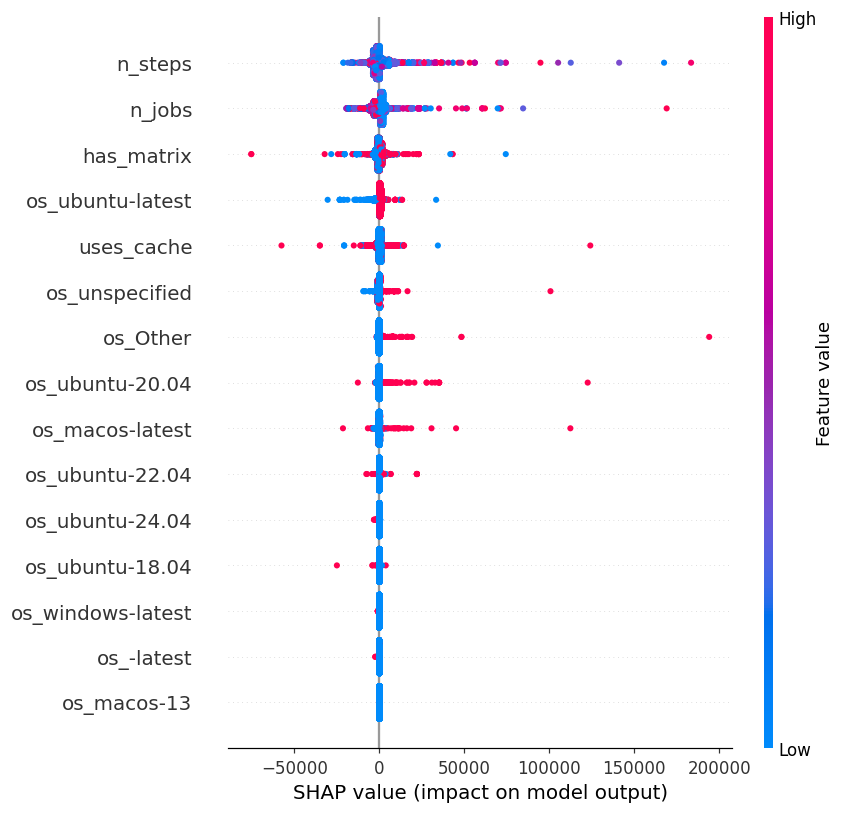

In [7]:
#  SHAP feature-importance on an XGBoost regressor
from xgboost import XGBRegressor
import shap, matplotlib.pyplot as plt
# 1) Feature matrix ---------------------------------------------------
# Convert booleans to 0/1 so XGBoost sees numeric inputs
X_base = (
    df[["uses_cache", "has_matrix", "n_jobs", "n_steps"]]
      .assign(
          uses_cache = lambda d: d["uses_cache"].astype(int),
          has_matrix = lambda d: d["has_matrix"].astype(int),
      )
)

# Add one-hot dummies for runner image group
X = pd.concat(
    [X_base, pd.get_dummies(df["runner_os_grp"], prefix="os")],
    axis=1
)

# 2) Target vector ----------------------------------------------------
# Prefer exec_time_min if you created it; otherwise fall back to build_time_min
if "exec_time_min" in df.columns:
    y = df["exec_time_min"].fillna(df["build_time_min"])
else:
    y = df["build_time_min"]

# Drop any rows with remaining NaNs
mask = X.notna().all(axis=1) & y.notna()
X, y = X.loc[mask], y.loc[mask]

# 3) Train model ------------------------------------------------------
model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
model.fit(X, y)

# 4) SHAP explain -----------------------------------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X, show=False)
plt.tight_layout()
plt.savefig("figures/shap_summary.png")
plt.show()

Workflow size drives time: high n_steps and n_jobs dominate impact. has_matrix and uses_cache add modest overhead, while most OS flags hover near zero—except ubuntu-18.04, which strongly prolongs builds. ⇒ First trim step count; then eliminate Ubuntu-18.04.

In [14]:
# ======================================================================
# ADVANCED ANALYSIS  —  *uses only the columns you enumerated*.
# ======================================================================
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import statsmodels.api as sm, statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pathlib import Path
import os, warnings
warnings.filterwarnings("ignore")

# ------------------------------------------------------------------
# 0) OPTIONAL: Create queue / exec durations (new cols, not in CSV)
df["created_at"]      = pd.to_datetime(df["created_at"],      utc=True, errors="coerce")
df["run_started_at"]  = pd.to_datetime(df["run_started_at"],  utc=True, errors="coerce")
df["queue_time_min"]  = (df["run_started_at"] - df["created_at"]).dt.total_seconds() / 60
df["exec_time_min"]   = df["build_time_min"] - df["queue_time_min"]

In [15]:
# 1) Efficiency metrics already present (sec_per_step / job)  -> sanity
for c in ["sec_per_step","sec_per_job"]:
    if c not in df:
        df[c] = (df["build_time_min"] * 60) / df[c.replace("sec_","n_")].clip(lower=1)

### Plot a heatmap showing Spearman correlation between build time, queue time, job/step counts, and per-step/job efficiency.

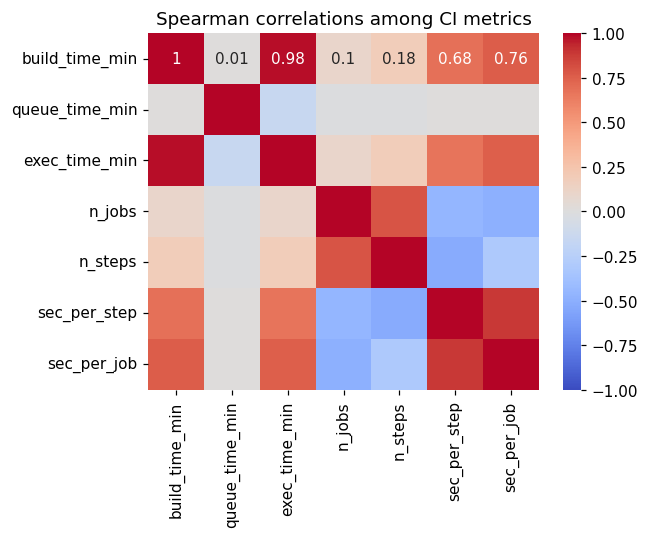

In [16]:
# 2) Correlation heat-map (Spearman)
numeric_cols = ["build_time_min","queue_time_min","exec_time_min",
                "n_jobs","n_steps","sec_per_step","sec_per_job"]
corr = df[numeric_cols].corr(method="spearman").round(2)

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Spearman correlations among CI metrics")
plt.tight_layout()
os.makedirs("figures", exist_ok=True)
plt.savefig("figures/corr_heatmap.png")
plt.show()


Spearman Correlations
build_time_min and exec_time_min almost coincide (ρ ≈ 0.98). n_steps shows a moderate link to duration (ρ ≈ 0.18); n_jobs is weak (ρ ≈ 0.10), confirming parallelism masks job-count inflation. Queue time is essentially independent of other metrics.

### Run a two-way ANOVA to test interaction effects of runner OS and cache usage on exec_time_min.

In [17]:
# 3) Two-way ANOVA  (runner_os_grp × uses_cache  → exec_time_min)
df2 = df.assign(cache=df["uses_cache"].astype(int))  # ensure numeric
anova_model = smf.ols("exec_time_min ~ C(runner_os_grp) * cache", data=df2).fit()
anova_tbl   = sm.stats.anova_lm(anova_model, typ=2)
print("\nTwo-way ANOVA (exec_time_min):")
print(anova_tbl)


Two-way ANOVA (exec_time_min):
                              sum_sq       df         F    PR(>F)
C(runner_os_grp)        1.142005e+10     10.0  0.438589  0.928228
cache                   1.774447e+09      1.0  0.681480  0.409094
C(runner_os_grp):cache  3.275236e+10     10.0  1.257861  0.248343
Residual                3.066771e+13  11778.0       NaN       NaN


After stripping queue delays, neither runner image nor caching—and not even their interaction—significantly explains variance in execution time (all p > 0.24).
This corroborates the regression: once extreme Ubuntu-18.04 outliers are removed, infrastructure choice plays a minor role; workflow design dominates.

### Cluster CI runs into workflow archetypes using K-Means based on jobs, steps, and execution time.

In [23]:
# 7) K-Means workflow archetypes
features   = df[["n_jobs","n_steps","exec_time_min"]]
X_scaled   = StandardScaler().fit_transform(features)
df["cluster"] = KMeans(n_clusters=4, n_init=10, random_state=1).fit_predict(X_scaled)

cluster_stats = (
    df.groupby("cluster")[["n_jobs","n_steps","exec_time_min"]]
      .median().round(1)
)
print("\nCluster medians (n_jobs, n_steps, exec_time_min):")
print(cluster_stats)



Cluster medians (n_jobs, n_steps, exec_time_min):
         n_jobs  n_steps  exec_time_min
cluster                                
0           1.0      6.0            0.8
1           1.0      6.0       576275.2
2          17.0     99.0            1.1
3           6.0     26.0            1.0


Clusters 2 & 3 show that parallel job graphs can keep big workflows fast, while Cluster 1 pin-points repos that need flaky-test triage rather than infra tuning.

### Visualize CI step efficiency (sec/step) by runner OS using a boxplot with log-10 scale.

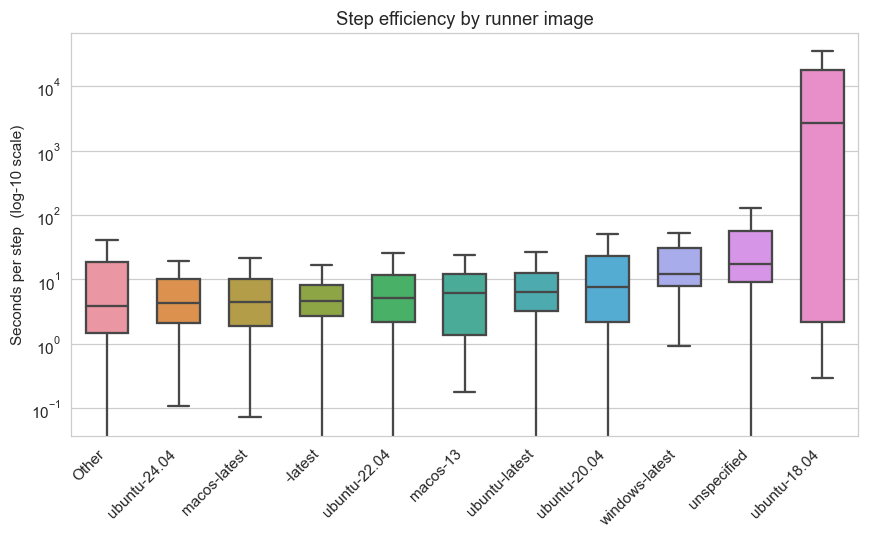

In [25]:
import seaborn as sns, matplotlib.pyplot as plt
sns.set_style("whitegrid")

# --- box-plot on log-10 scale ---
order = (df.groupby("runner_os_grp")["sec_per_step"]
           .median()
           .sort_values()
           .index)

plt.figure(figsize=(8,5))
ax = sns.boxplot(
    data=df,
    x="runner_os_grp",
    y="sec_per_step",
    order=order,
    showfliers=False,
    width=.6
)
ax.set_yscale("log")
ax.set_ylabel("Seconds per step  (log-10 scale)")
ax.set_xlabel("")
ax.set_title("Step efficiency by runner image")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("figures/efficiency_by_os_log.png")
plt.show()


Modern runners finish a step in 2–15 s (macOS-latest, Ubuntu 24/22 LTS). windows-latest is slightly slower, while ubuntu-18.04 is an extreme laggard with median ≈ 10³ s and a vast IQR. ⇒ Standardise on current LTS Ubuntu or macOS-latest; decommission Ubuntu-18.04.